In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from utils import *
import matplotlib
sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.figsize': (6,5), 'figure.dpi': 150})

# Process results

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_2/')

In [10]:
data_df = pd.read_csv(data_path / 'summary.csv').drop(['Unnamed: 0'],axis=1)

In [30]:
data_df['path'] = data_df.apply(lambda x: pathlib.Path(x.path), axis=1)

In [28]:
errors = compute_errors(data_path)

  0%|          | 0/400 [00:00<?, ?it/s]

In [33]:
for k, df in errors.items():
    errors[k] = pd.merge(
        df, 
        data_df.loc[:, ['path', 'W_condition', 'W_smin', 'W_smax', 'x_condition',
           'x_smin', 'x_smax', 'cov_condition', 'cov_smin', 'cov_smax']],
        on='path'
    )

In [40]:
for k, df in errors.items():
    errors[k]['sigma'] = df.apply(lambda x: x['glorot_normal']['sigma'], axis=1)

/tmp/ipykernel_3523530/1664357662.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(mnorm.inverse(cbar.ax.get_yticks()).round())


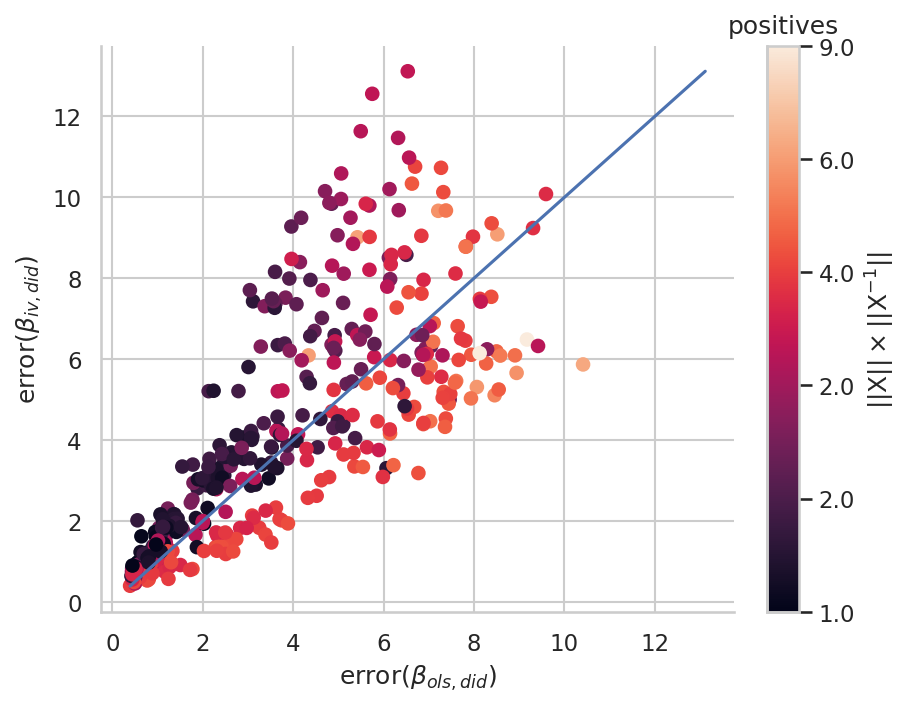

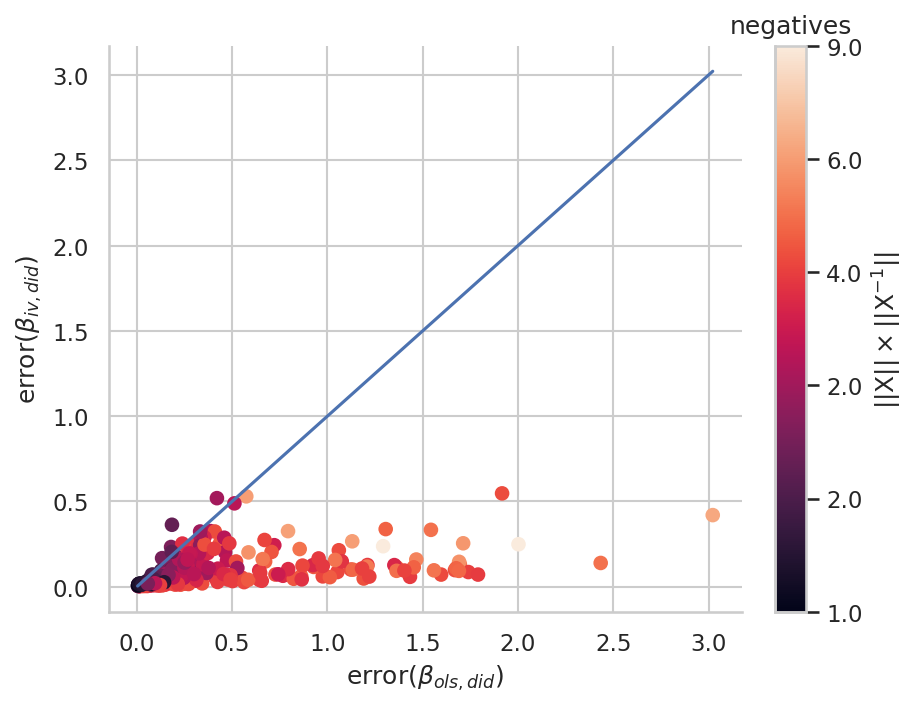

In [36]:
for k in errors:
    var1 = 'error_beta_ols_did'
    var2 = 'error_beta_iv_did'
    fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(6,5), dpi=150)
    mnorm = matplotlib.colors.LogNorm()
    xmin, xmax = min(errors[k][var1].min(), errors[k][var2].min()), max(errors[k][var1].max(), errors[k][var2].max())
    sc = ax.scatter(errors[k][var1], errors[k][var2], c=mnorm(errors[k].x_condition))
    ax.plot([xmin, xmax], [xmin, xmax])
    ax.set_xlabel(fr'$\mathrm{{error}}(\beta_{{{",".join(var1.split("_")[2:])}}})$')
    ax.set_ylabel(fr'$\mathrm{{error}}(\beta_{{{",".join(var2.split("_")[2:])}}})$')
    cbar = plt.colorbar(sc, cax=cax)
    cbar.ax.set_yticklabels(mnorm.inverse(cbar.ax.get_yticks()).round())
    cbar.ax.set_ylabel(r'$||\mathrm{X}|| \times ||\mathrm{X}^{-1}||$')
    sns.despine()
    plt.title(k)

<AxesSubplot:xlabel='stim_strength', ylabel='sigma'>

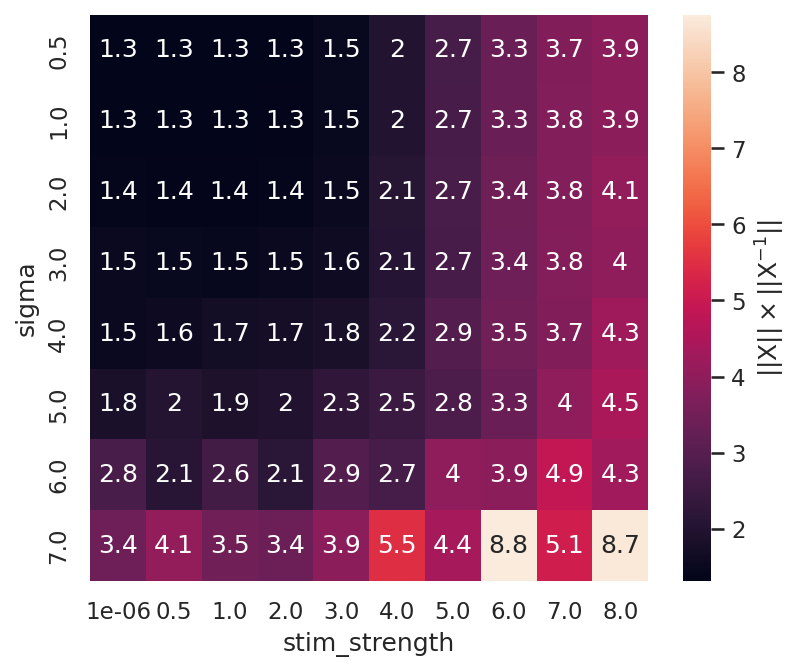

In [43]:
sns.heatmap(
    errors[k].query('n_neurons==50').pivot('sigma', 'stim_strength', 'x_condition'), 
    annot=errors[k].query('n_neurons==50').pivot('sigma', 'stim_strength', 'x_condition'),
    cbar_kws={'label': r'$||\mathrm{X}|| \times ||\mathrm{X}^{-1}||$'}
)

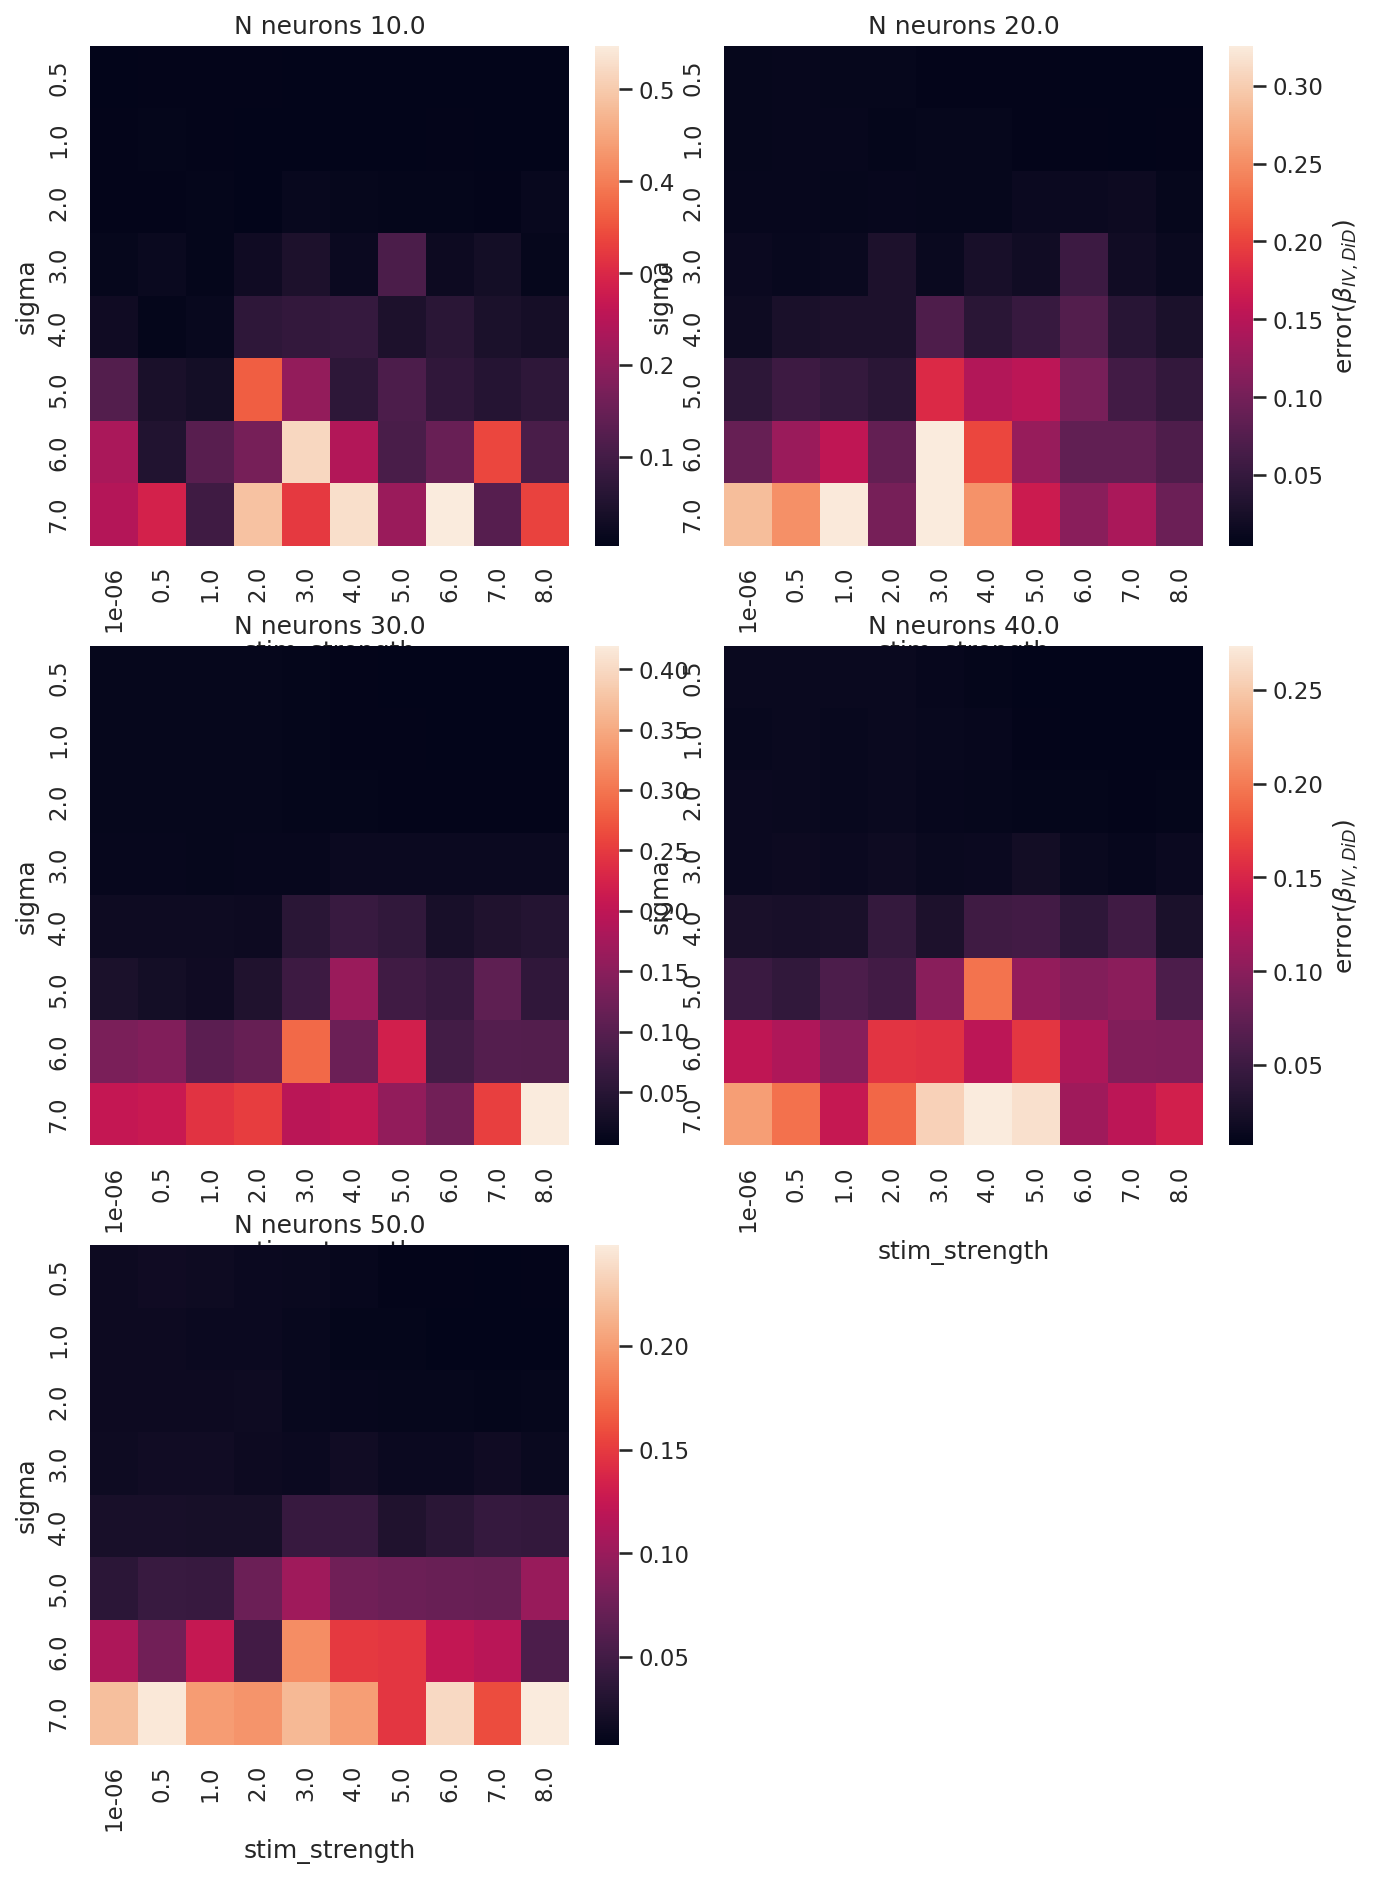

In [45]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10,15))
gs = gridspec.GridSpec(3, 2, figure=fig)
for i, (n_neurons, df) in enumerate(errors[k].groupby('n_neurons')):
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[i], width_ratios=[1,0.05], wspace=0.1)
    ax = fig.add_subplot(gs00[0,0])
    cax = fig.add_subplot(gs00[0,1])
    sns.heatmap(
        df.pivot('sigma', 'stim_strength', 'error_beta_iv_did'), 
#         annot=df.pivot('sigma', 'stim_strength', 'error_beta_iv_did'), 
        cbar_ax=cax, ax=ax, cbar_kws={'label': r'$\mathrm{error}(\beta_{IV,DiD})$' if i%2!=0 else ''})
    ax.set_title(f'N neurons {n_neurons}')

In [48]:
def violin_compare(var1, var2, x='stim_strength', k='positives'):
    plt.figure()
    v1 = errors[k].loc[:, [x, var1]].rename(columns={var1: 'Error'})
    key = lambda x: ','.join(x.split('_')[2:])
    v1[''] = key(var1)
    v2 = errors[k].loc[:, [x, var2]].rename(columns={var2: 'Error'})
    v2[''] = key(var2)
    viodf = pd.concat([v1,v2])
    sns.violinplot(
        data=viodf, x=x, y='Error', hue='', split=True, inner="quart", linewidth=1,
                   palette={key(var1): "b", key(var2): ".85"}, cut=0,
    )
    sns.despine()
    plt.legend(frameon=False, loc=1)
    plt.title(k)

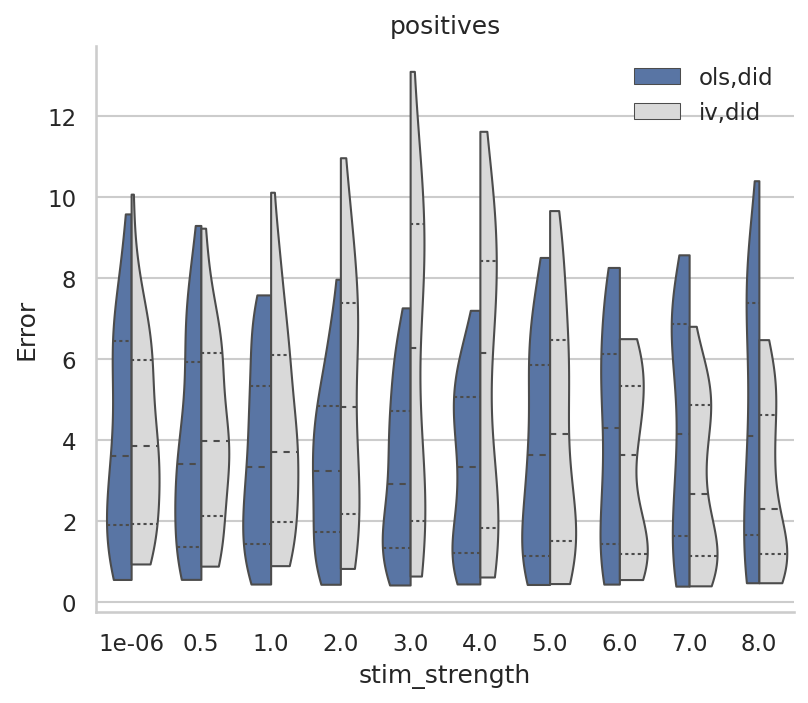

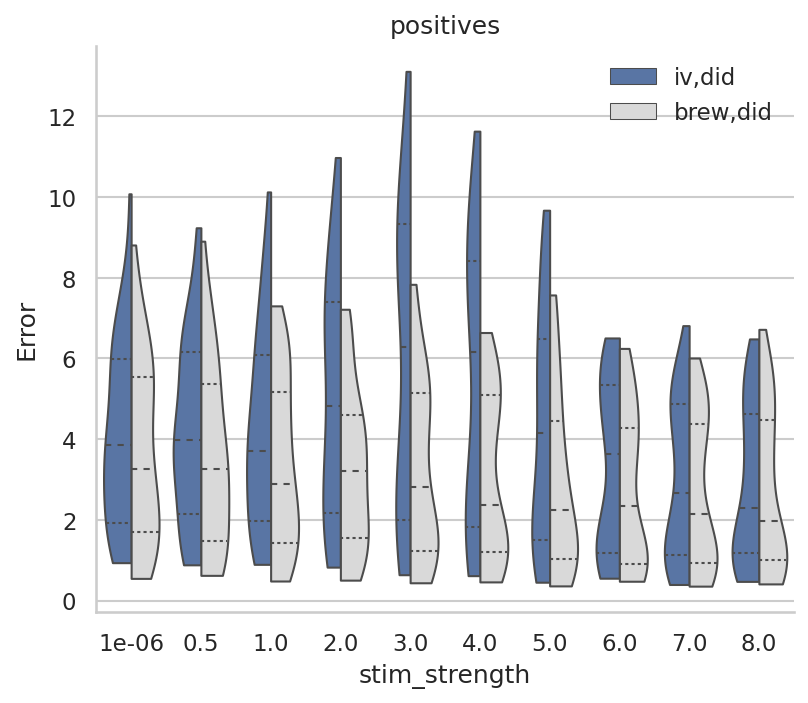

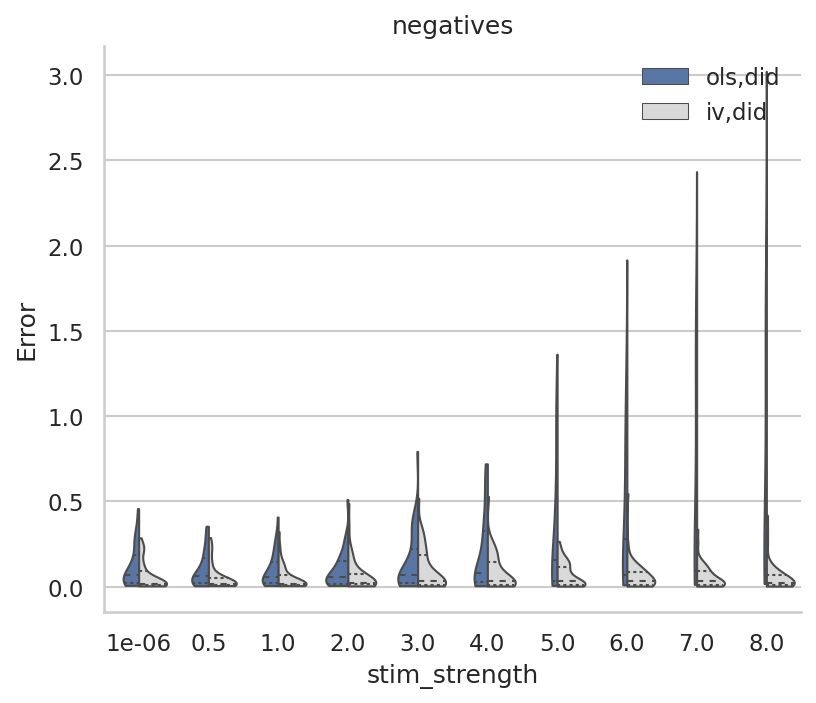

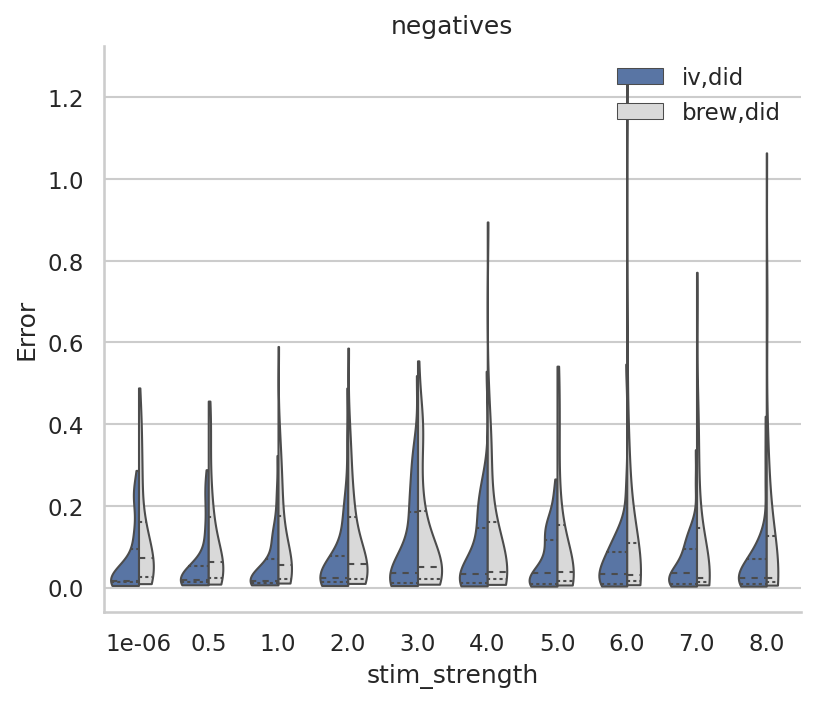

In [49]:
for k in errors:
    violin_compare('error_beta_ols_did', 'error_beta_iv_did', k=k)
    violin_compare('error_beta_iv_did', 'error_beta_brew_did', k=k)

In [52]:
def violin_compare_all(var_list, k):
    plt.figure()
    key = lambda x: ','.join(x.split('_')[2:])
    viodf = pd.DataFrame()
    for var in var_list:
        v = pd.DataFrame()
        v['Error'] = errors[k].loc[:, var]
        v[''] = key(var)
        viodf = pd.concat([viodf,v])
    sns.violinplot(
        data=viodf, x='', y='Error', inner="quart", linewidth=1, cut=0,
    )
    sns.despine()
    plt.title(k)

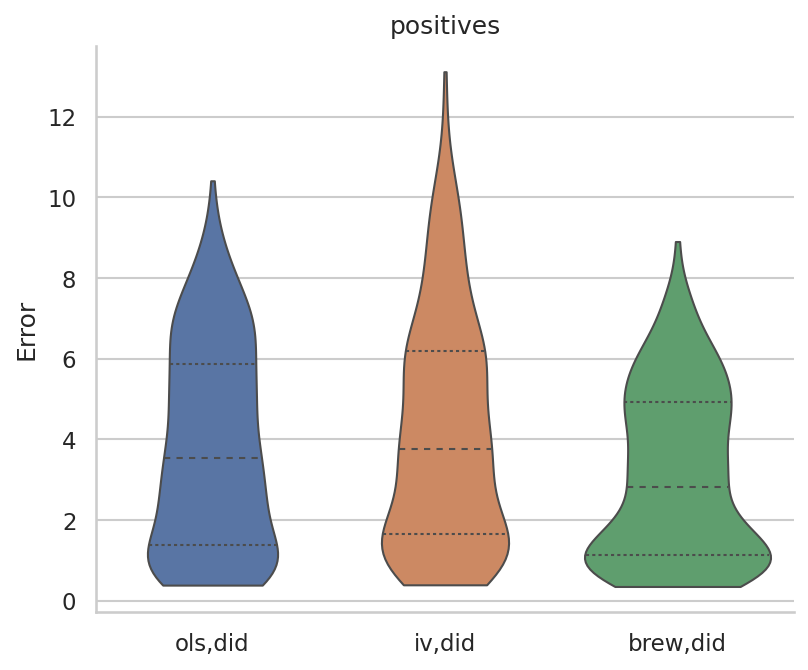

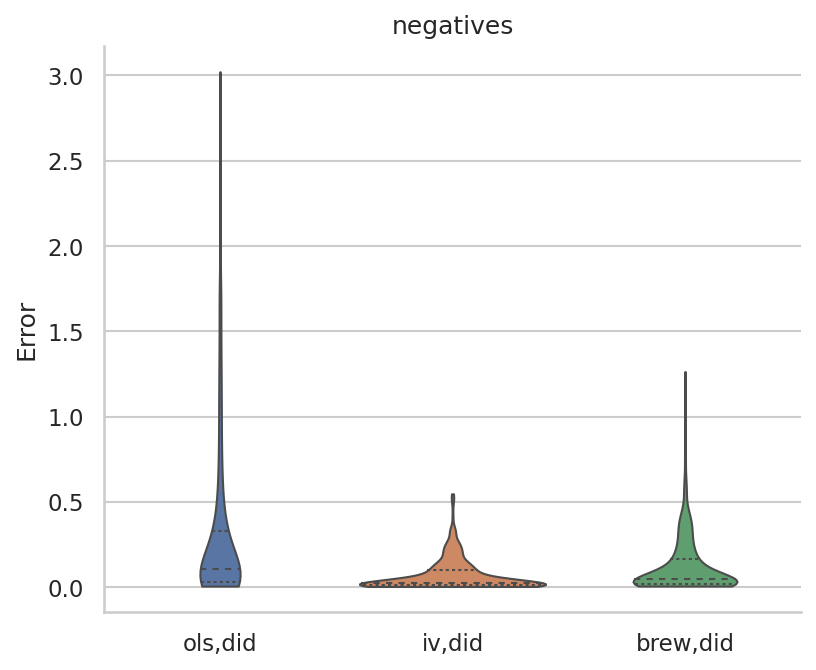

In [53]:
for k in errors:
    violin_compare_all(['error_beta_ols_did', 'error_beta_iv_did', 'error_beta_brew_did'], k=k)

# Compare error between OLS and IV

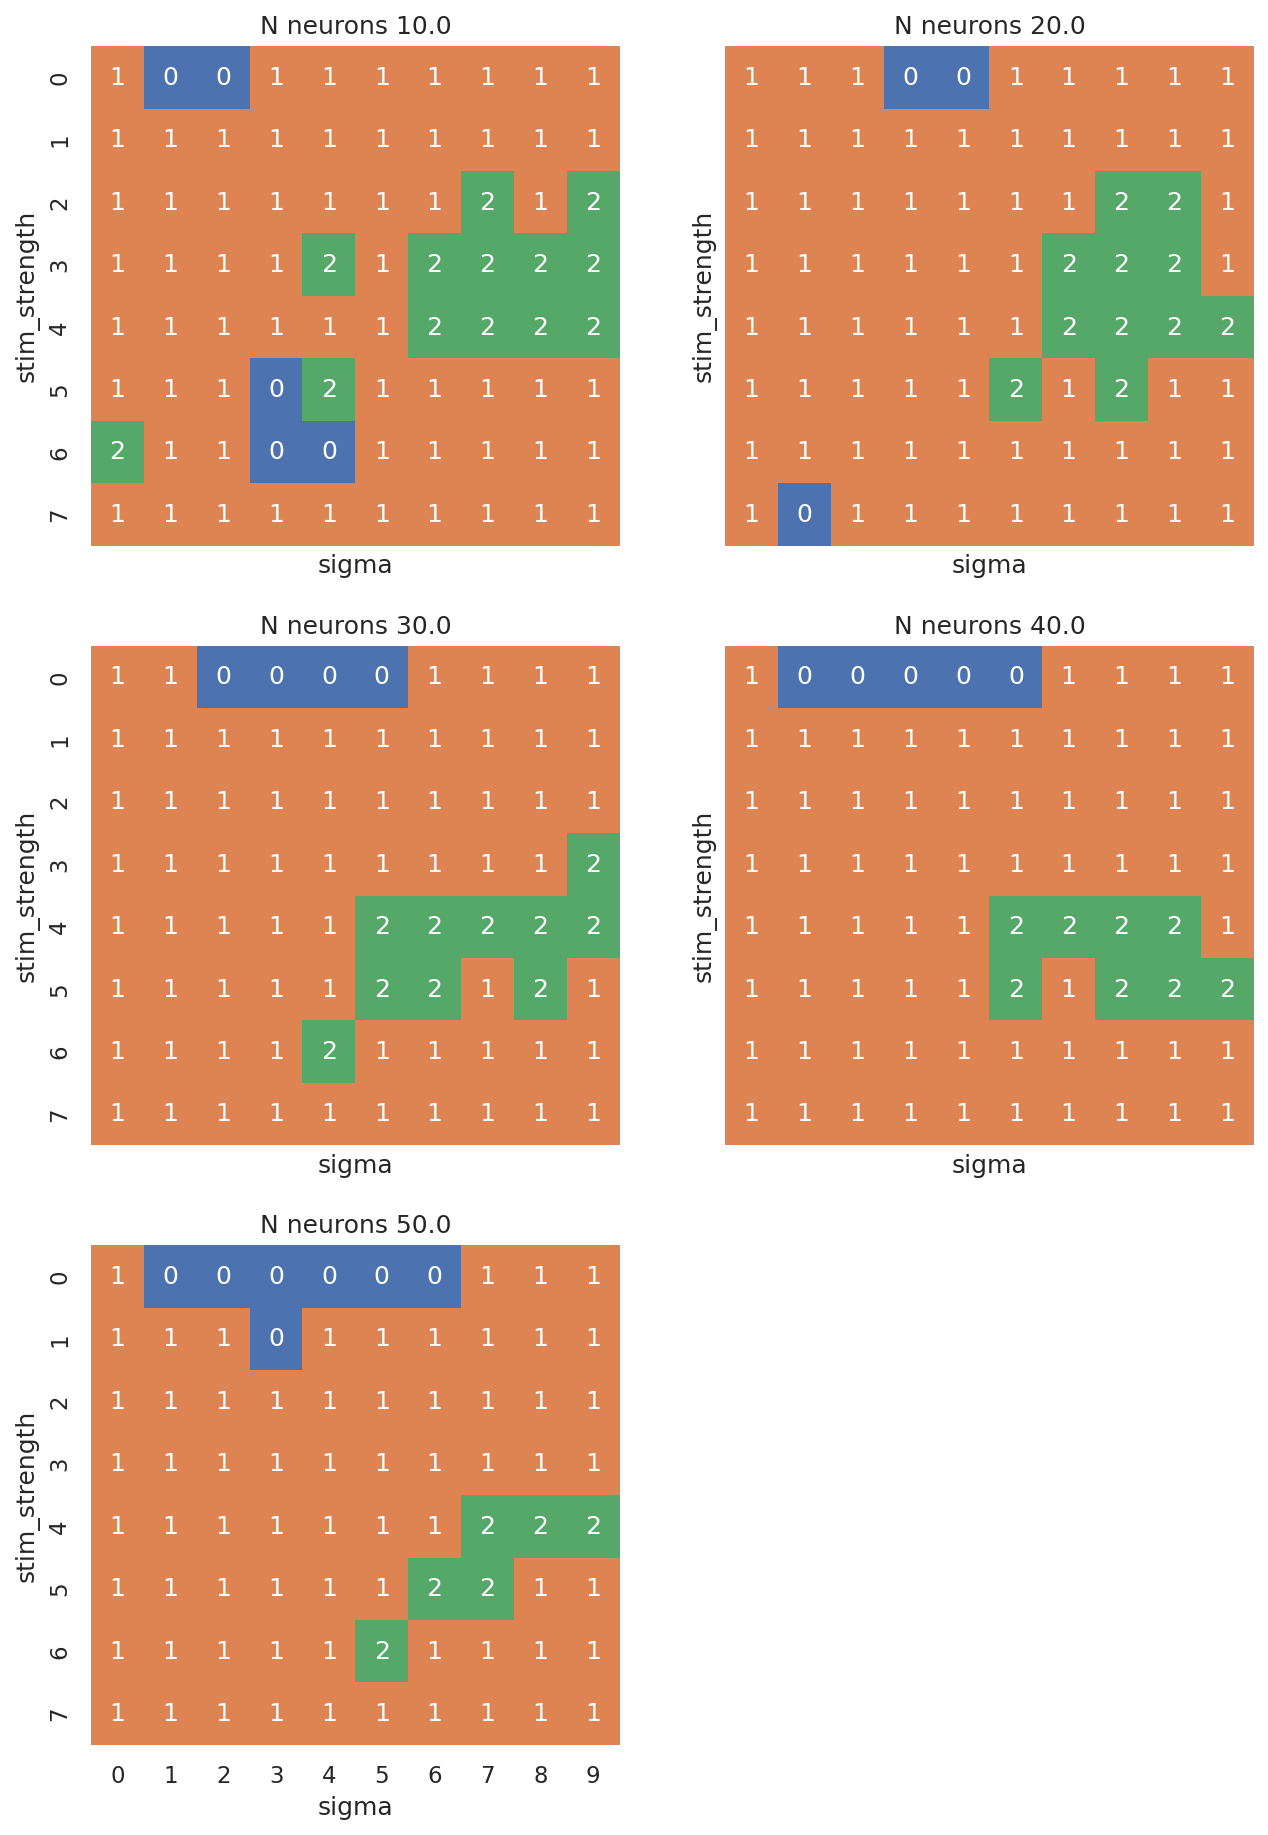

In [55]:
k = 'negatives'
import matplotlib.gridspec as gridspec
fig, axs = plt.subplots(3, 2, figsize=(10,15), sharex=True, sharey=True)
axs = axs.ravel()
axs[-1].remove()
for i, (n_neurons, df) in enumerate(errors[k].groupby('n_neurons')):
    ax = axs[i]
    argmin_err = np.concatenate(
    [df.pivot('sigma', 'stim_strength', 'error_beta_ols_did').values[:,:,None], 
     df.pivot('sigma', 'stim_strength', 'error_beta_iv_did').values[:,:,None], 
     df.pivot('sigma', 'stim_strength', 'error_beta_brew_did').values[:,:,None]], axis=2).argmin(2)
    sns.heatmap(
        argmin_err, 
        annot=argmin_err, 
        cmap=['C0', 'C1', 'C2'], vmin=0, vmax=2, ax=ax, cbar=False)
    ax.set_title(f'N neurons {n_neurons}')

    ax.set_xlabel('sigma')
    ax.set_ylabel('stim_strength')

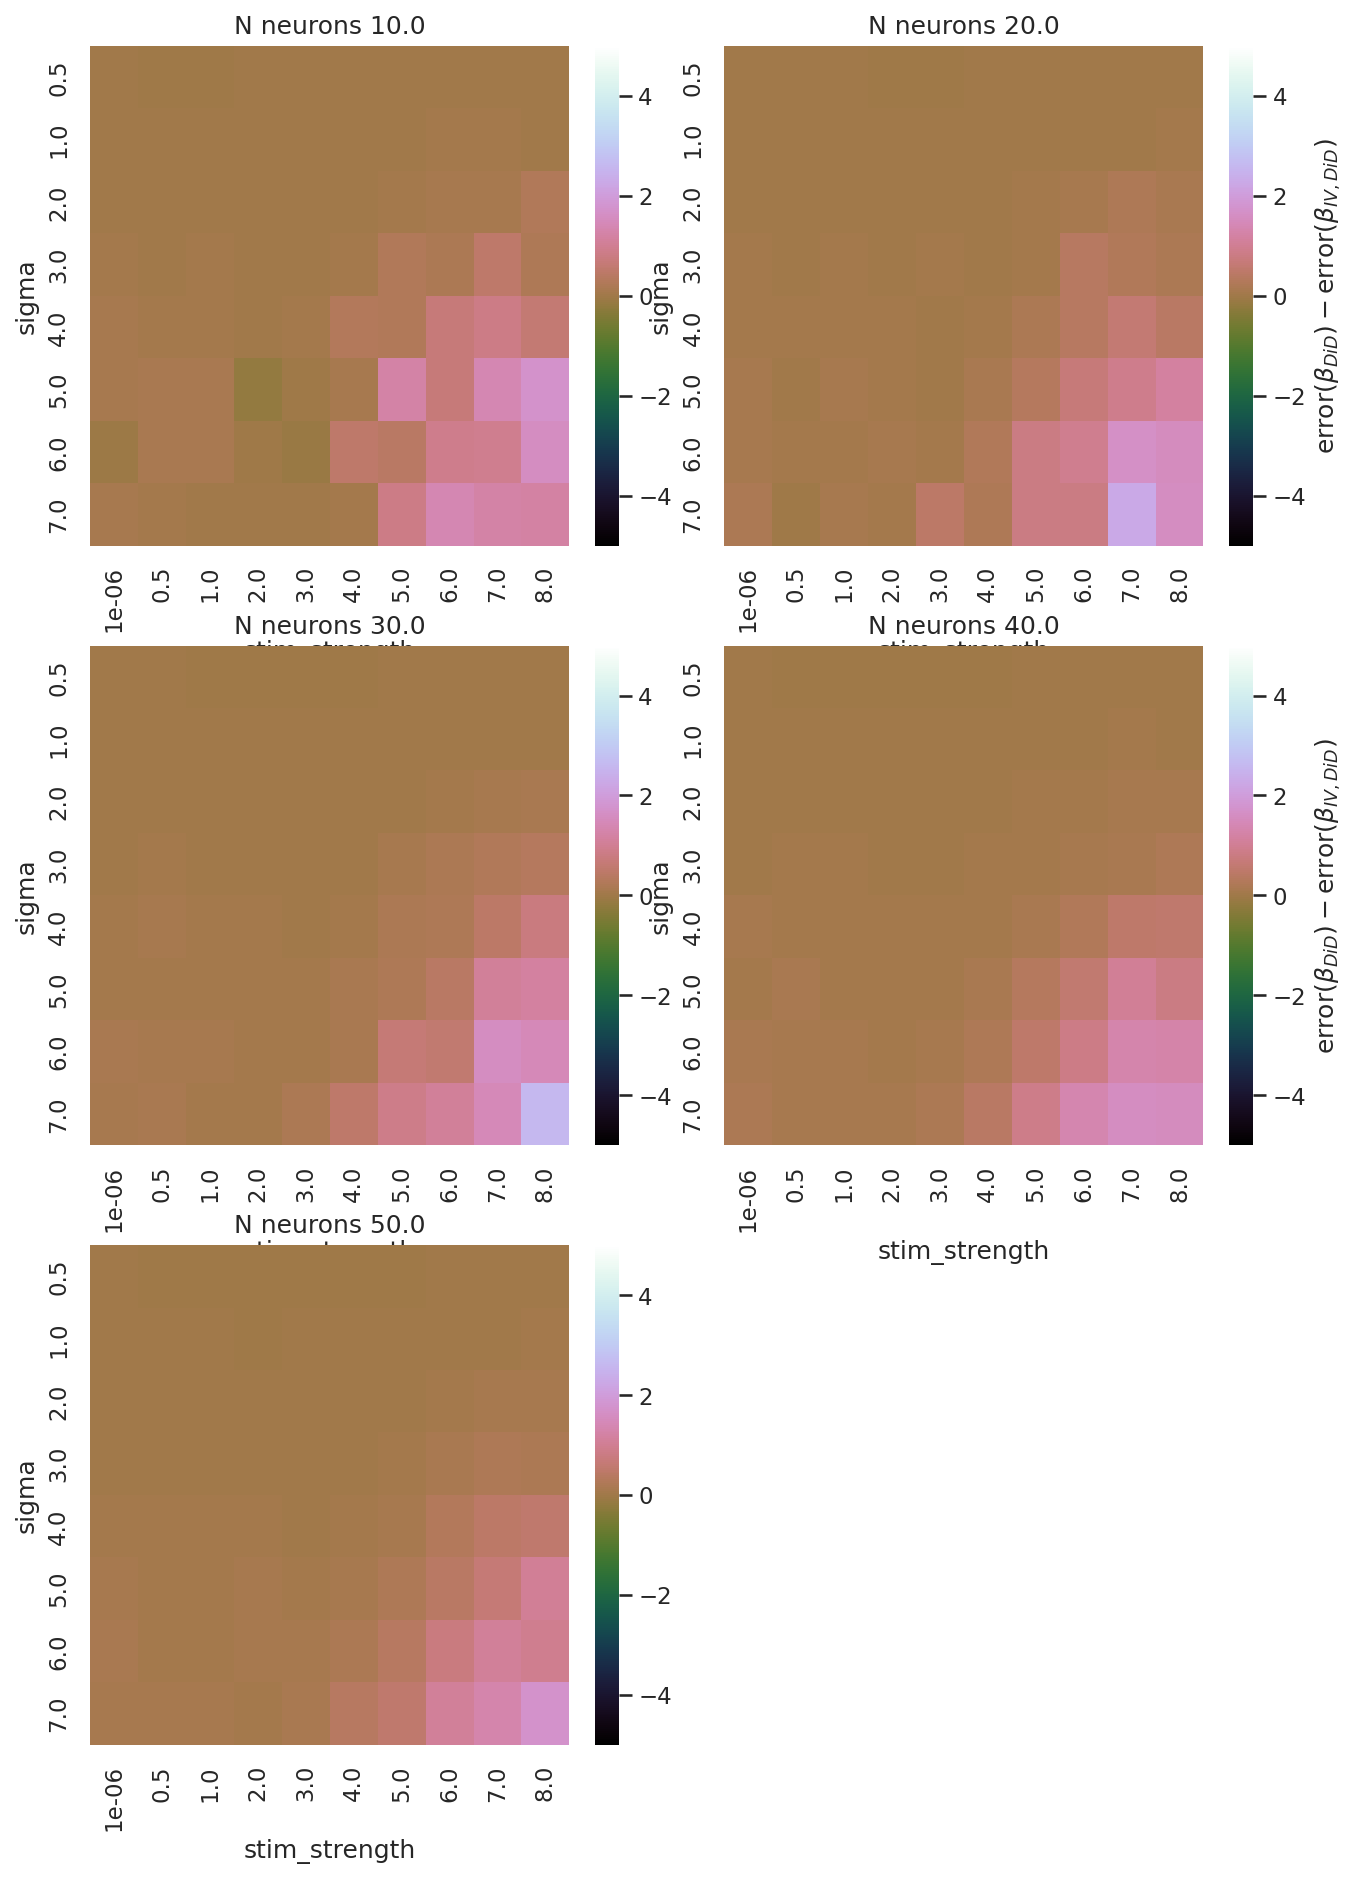

In [58]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10,15))
gs = gridspec.GridSpec(3, 2, figure=fig)
for i, (n_neurons, df) in enumerate(errors[k].groupby('n_neurons')):
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[i], width_ratios=[1,0.05], wspace=0.1)
    ax = fig.add_subplot(gs00[0,0])
    cax = fig.add_subplot(gs00[0,1])
    sns.heatmap(
        df.pivot('sigma', 'stim_strength', 'error_beta_ols_did') - df.pivot('sigma', 'stim_strength', 'error_beta_iv_did'), 
#         annot=df.pivot('sigma', 'stim_strength', 'error_diff_ols_iv_did'), 
        cmap='cubehelix', vmin=-5, vmax=5, cbar_ax=cax, ax=ax, 
        cbar_kws={'label': r'$\mathrm{error}(\beta_{DiD}) - \mathrm{error}(\beta_{IV,DiD})$' if i%2!=0 else ''})
    ax.set_title(f'N neurons {n_neurons}')

# Convergence

In [59]:
error_convergence = compute_error_convergence(data_path)

  0%|          | 0/44800 [00:00<?, ?it/s]

In [64]:
samples = compute_all_samples(data_path)

  0%|          | 0/400 [00:00<?, ?it/s]

In [60]:
index = errors[k].query('n_neurons==50 and stim_strength==7 and sigma==6').iloc[0].name

In [61]:
index

270

In [62]:
errors[k].loc[index]

path                   /home/users/bjornmik/datasets/sweep_2/n50_ss7_s6
const                                                               5.0
n_neurons                                                          50.0
n_stim                                                              5.0
dt                                                                0.001
ref_scale                                                          10.0
abs_ref_scale                                                       3.0
spike_scale                                                         5.0
abs_ref_strength                                                 -100.0
rel_ref_strength                                                  -30.0
stim_scale                                                          2.0
stim_strength                                                       7.0
stim_period                                                        50.0
stim_isi_min                                                    

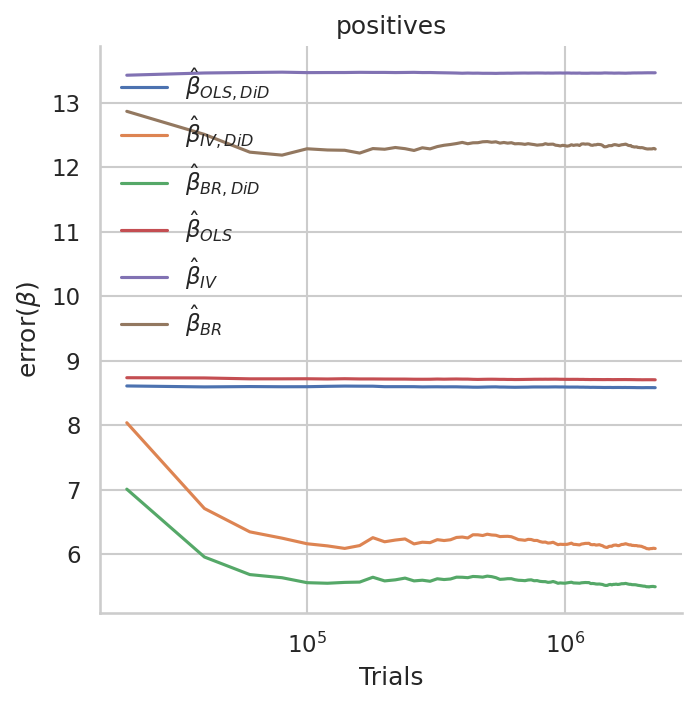

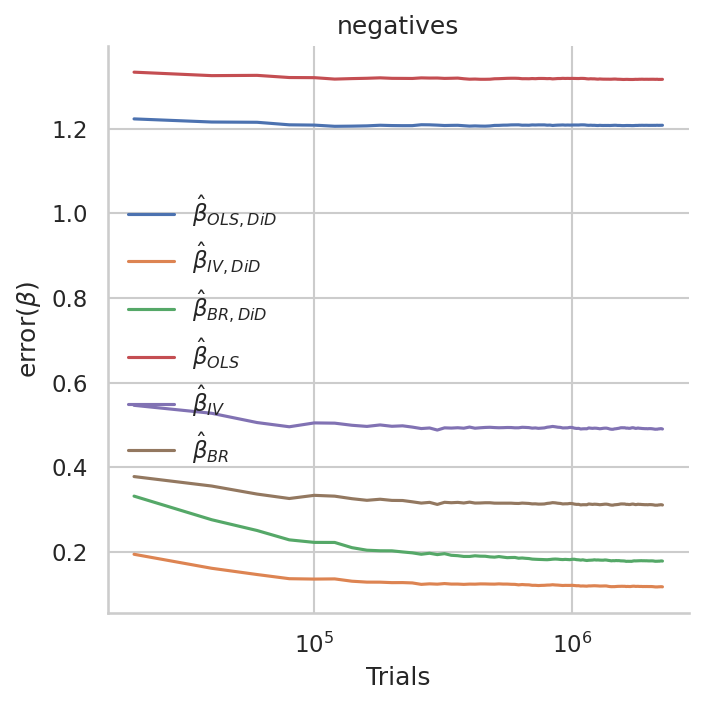

In [63]:
plot_error_convergence(error_convergence, index)

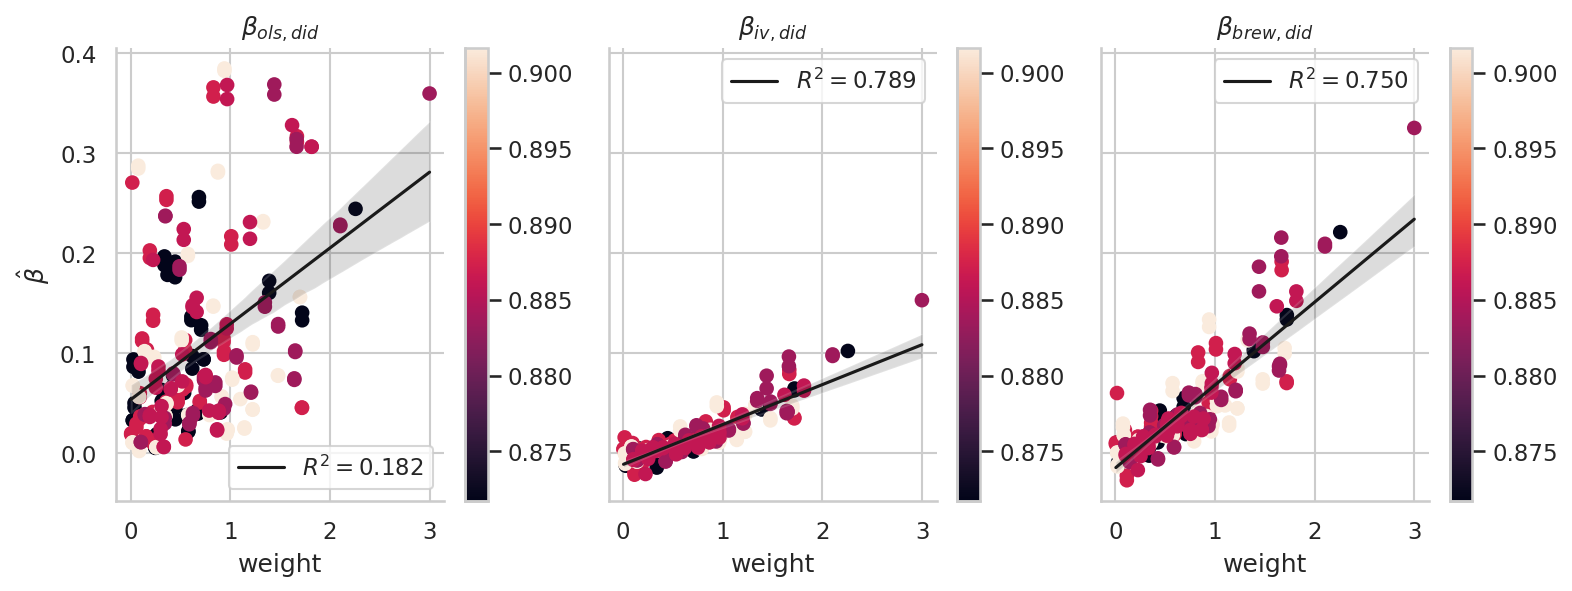

In [65]:
plot_regression(samples, index, ['beta_ols_did','beta_iv_did','beta_brew_did'])

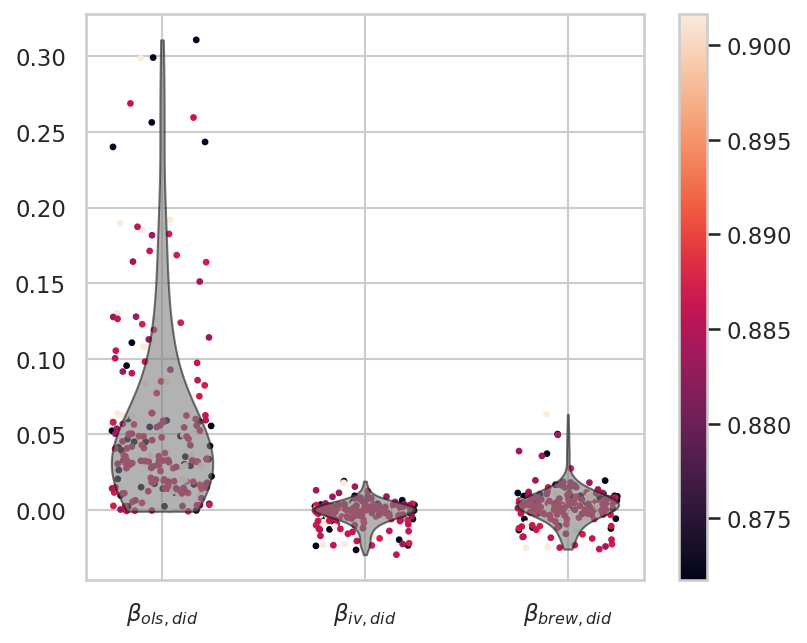

In [66]:
plot_false_positives(samples, index, ['beta_ols_did', 'beta_iv_did', 'beta_brew_did'])